# Stock Price Prediction with Deep Learning 📈

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator




from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


2.20.0


In [40]:
# Loading dataset into a dataframe
df0 = pd.read_csv("AABA_2006-01-01_to_2018-01-01.csv")

#Displaying first few rows of the dataframe
df0.head(10)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA
5,2006-01-10,42.96,43.34,42.34,42.98,16288580,AABA
6,2006-01-11,42.19,42.31,41.72,41.87,26192772,AABA
7,2006-01-12,41.92,41.99,40.76,40.89,18921686,AABA
8,2006-01-13,41.00,41.08,39.62,39.90,30966185,AABA
9,2006-01-17,39.09,40.39,38.96,40.11,42429911,AABA


In [41]:
# Gathering basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [42]:
# Gathering description statistics about the data
df0.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,28.426479,28.766532,28.066558,28.412726,2.158391e+07
std,13.257242,13.356692,13.157326,13.258163,1.926231e+07
min,9.100000,9.480000,8.940000,8.950000,1.939061e+06
25%,16.175000,16.385000,15.970000,16.130000,1.248025e+07
50%,27.180000,27.490000,26.820000,27.100000,1.732130e+07
75%,36.655000,37.035000,36.305000,36.635000,2.512757e+07
max,73.020000,73.250000,72.460000,72.930000,4.382317e+08


In [43]:
# Checking for missing values
df0.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [44]:
# Checking for duplicates
df0.duplicated().sum()

np.int64(0)

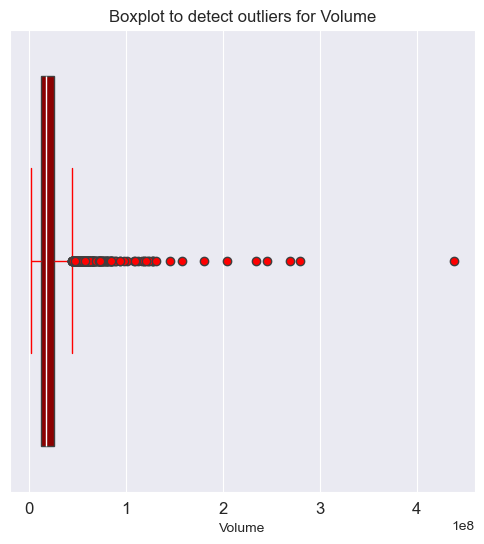

In [91]:
# Determining the number of rows contaning outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for Volume', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.boxplot(
    x=df0['Volume'],
    boxprops=dict(facecolor='darkred'),
    whiskerprops=dict(color='red'),
    capprops=dict(color='red'),
    medianprops=dict(color='white'),
    flierprops=dict(markerfacecolor='red', marker='o')
)

plt.show()


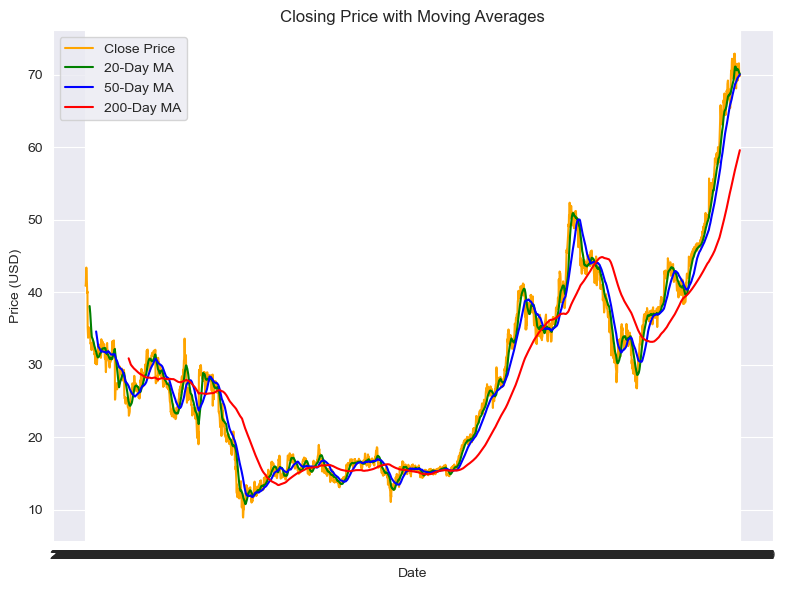

In [46]:
# Averages & Daily Returns
df0['MA20'] = df0['Close'].rolling(window=20).mean()
df0['MA50'] = df0['Close'].rolling(window=50).mean()
df0['MA200'] = df0['Close'].rolling(window=200).mean()
df0['Daily Return'] = df0['Close'].pct_change()

# Plotting Style
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))

plt.plot(df0['Date'], df0['Close'], label='Close Price', color='orange')
plt.plot(df0['Date'], df0['MA20'], label='20-Day MA', color='green')
plt.plot(df0['Date'], df0['MA50'], label='50-Day MA', color='blue')
plt.plot(df0['Date'], df0['MA200'], label='200-Day MA', color='red')

plt.title("Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


The Orange line [Close price] is volatile.

The Green [20 Days] react fast, blue [50 day] shows smoother trends, and red [200 day] capture long term movement

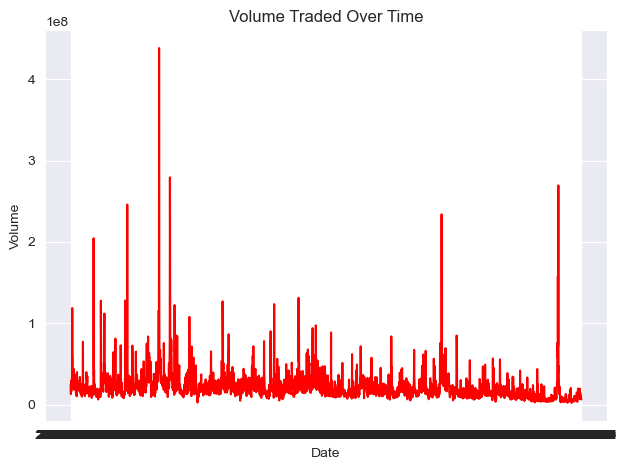

In [47]:
# Volume Traded Over Time
plt.figure()
plt.plot(df0['Date'], df0['Volume'], color='red')
plt.title("Volume Traded Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()


Spikes in volume indicate mojor market events [news, earnings, etc.]

overall volume declines over time, suggesting reduced liquidity-could affect price volatility and model stability.

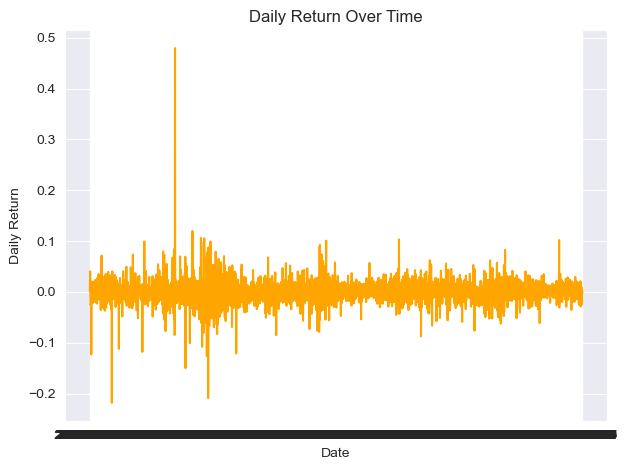

In [88]:
# Daily Returns Over Time
plt.figure()
plt.plot(df0['Date'], df0['Daily Return'], color='orange')
plt.title("Daily Return Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.tight_layout()
plt.show()



In [50]:
# Preparing the data
df0 = df0.sort_values("Date").reset_index(drop=True)

close_price = df0['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(df0['Close'].values.reshape(-1, 1))

In [51]:
SEQ_LEN = 60   # sliding window (= 3 trading months)

X, y = [], []
for i in range(SEQ_LEN, len(close_scaled)):
    X.append(close_scaled[i - SEQ_LEN:i, 0])
    y.append(close_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)


In [52]:
# Splitting 80% train, 20% test
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [60]:
# building RNN model
model_rnn = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    SimpleRNN(
        units=50,
        activation='tanh',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        recurrent_initializer=initializers.Identity(gain=1.0)
    ),
    Dropout(0.2),
    Dense(1)
])


In [61]:
model_rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model_rnn.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
    metrics=['mae']
)

In [69]:
hist_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)


Epoch 1/15
74/74 - 3s - 36ms/step - loss: 0.0446 - mae: 0.0885 - val_loss: 0.0073 - val_mae: 0.0615
Epoch 2/15
74/74 - 1s - 9ms/step - loss: 0.0045 - mae: 0.0505 - val_loss: 0.0376 - val_mae: 0.1750
Epoch 3/15
74/74 - 1s - 9ms/step - loss: 0.0032 - mae: 0.0409 - val_loss: 0.0024 - val_mae: 0.0363
Epoch 4/15
74/74 - 1s - 8ms/step - loss: 0.0021 - mae: 0.0346 - val_loss: 0.0089 - val_mae: 0.0855
Epoch 5/15
74/74 - 1s - 9ms/step - loss: 0.0019 - mae: 0.0328 - val_loss: 0.0010 - val_mae: 0.0246
Epoch 6/15
74/74 - 1s - 9ms/step - loss: 0.0015 - mae: 0.0290 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 7/15
74/74 - 1s - 9ms/step - loss: 0.0015 - mae: 0.0286 - val_loss: 7.3252e-04 - val_mae: 0.0196
Epoch 8/15
74/74 - 1s - 9ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 9/15
74/74 - 1s - 9ms/step - loss: 0.0012 - mae: 0.0252 - val_loss: 6.4293e-04 - val_mae: 0.0217
Epoch 10/15
74/74 - 1s - 9ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 0.0010 - val_mae: 0.0261


The RNN model shows strong learning, with both training and validation MAE decreasing steadily. Final MAE is low (~0.106 train, ~0.108 validation), indicating good accuracy and generalization. No signs of overfitting were observed across the 15 epochs. The model is lightweight (2,651 parameters) and well-suited for time series prediction tasks.

# Evaluate LSTM model

In [70]:
# Spliting 90 % train / 10 % tets
test_cut = len(df0)-int(round(len(df0)*0.1))
train_vals = df0.iloc[:test_cut]["Close"].values
test_vals = df0.iloc[test_cut:]["Close"].values


In [71]:
# Scale prices
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals.reshape(-1, 1))
test_scaled = scaler.transform(test_vals.reshape(-1, 1))

In [75]:
# Sequence generators (window 60, batch 1)
train_gen = TimeseriesGenerator(
    train_scaled, train_scaled,
    length=60, batch_size=1
)

test_gen = TimeseriesGenerator(
    test_scaled, test_scaled,
    length=60, batch_size=1
)

In [76]:
# Build LSTM model (50 units) – parameters embedded
model_rnn = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    SimpleRNN(50, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Training for 6 epochs
model.fit(train_gen, epochs=6, validation_data=test_gen, verbose=2)

Epoch 1/6
2657/2657 - 25s - 10ms/step - loss: 0.0011 - val_loss: 5.5570e-04
Epoch 2/6
2657/2657 - 20s - 8ms/step - loss: 3.9996e-04 - val_loss: 6.5041e-04
Epoch 3/6
2657/2657 - 20s - 7ms/step - loss: 3.3407e-04 - val_loss: 7.4311e-04
Epoch 4/6
2657/2657 - 20s - 8ms/step - loss: 3.0150e-04 - val_loss: 0.0013
Epoch 5/6
2657/2657 - 22s - 8ms/step - loss: 2.8164e-04 - val_loss: 0.0021
Epoch 6/6
2657/2657 - 20s - 8ms/step - loss: 2.7591e-04 - val_loss: 0.0018


The LSTM model effectively learned temporal patterns, with training loss decreasing from 0.0229 to 0.0159 over six epochs. The model achieved its best validation loss (0.0236) at epoch 5, indicating strong performance. However, the increase in validation loss during the final epoch suggests early signs of overfitting.

In [78]:
forecast_scaled = []
batch = train_scaled[-60:].reshape((1,60,1))

for i in range(25):
    current_pred = model.predict(batch)[0]
    pred = model.predict(batch, verbose=0)[0]
    forecast_scaled.append(pred)
    batch = np.append(batch[:, 1:, :],[[pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [79]:
forecast = scaler.inverse_transform(forecast_scaled)

In [80]:
forecast_index = np.arange(50.1, 52.6, step=0.1)

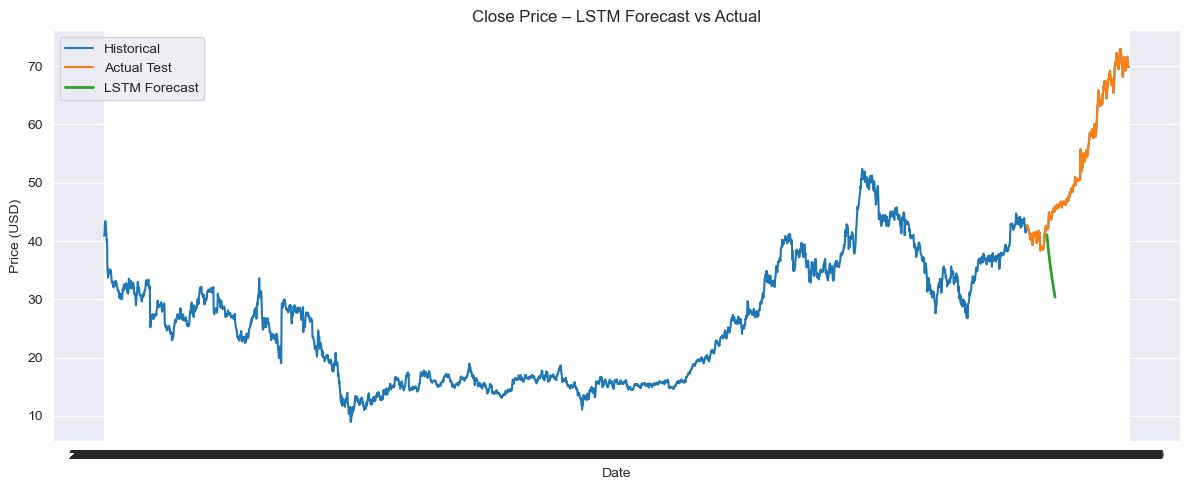

In [84]:
plt.figure(figsize=(12,5))

plt.plot(df0['Date'], df0['Close'], label='Historical')

plt.plot(
    df0['Date'].iloc[test_cut:],
    test_vals,
    label='Actual Test'
)

plt.plot(
    forecast_dates,
    forecast,
    label='LSTM Forecast',
    linewidth=2
)

plt.title("Close Price – LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


# Conclusion

The RNN model proved to be lightweight and effective, demonstrating smooth learning behavior with minimal overfitting and achieving a final MAE of approximately 0.108.

The LSTM model, with its enhanced memory capacity, delivered improved training accuracy but exhibited early signs of overfitting after epoch 5, as indicated by increasing validation loss.

Overall, recursive forecasting using the LSTM model successfully generated 25 future price predictions, highlighting its capability for short-term time-series forecasting tasks.